In [1]:
# AndroidWorld 轨迹可视化

# 这个 notebook 用于可视化 `runs/xxx` 下的轨迹：

# - 展示 **Goal(指令)** + **整条轨迹**
# - 每个 step：展示 `screenshot_step{n}.png`，并 `print` 对应的 `model_response`（即 `result.json` 里的 `trajectory[n].response`）
# - 若该 step 的 tool call 是 `click` 或 `long_press`，在截图上用 **红色圆圈** 标注点击点


from __future__ import annotations

from pathlib import Path
import json
import re

from PIL import Image, ImageDraw
from IPython.display import display, Markdown

RUNS_DIR = Path("/Users/chengkanzhi/Desktop/ScaleCUA/evaluation/AndroidWorld/runs/diy_0224")

_TOOL_RE = re.compile(r"<tool_call>\s*(\{.*?\})\s*</tool_call>", re.DOTALL)


def _extract_click_actions(response_text: str):
    """从 response 里抽取 click/long_press。

    注意：AndroidWorld 的坐标是归一化到 [0, 1000] 的。
    """

    actions = []
    for m in _TOOL_RE.finditer(response_text or ""):
        try:
            call = json.loads(m.group(1))
        except Exception:
            continue

        args = (call or {}).get("arguments") or {}
        action = args.get("action")
        if action not in {"click", "long_press"}:
            continue

        coord = args.get("coordinate")
        if isinstance(coord, (list, tuple)) and len(coord) == 2:
            # 坐标归一化到 0-1000
            actions.append({"action": action, "x_norm": float(coord[0]), "y_norm": float(coord[1])})

    return actions


def _annotate_clicks(img: Image.Image, actions):
    if not actions:
        return img

    img = img.convert("RGBA")
    draw = ImageDraw.Draw(img)
    w, h = img.size
    r = max(10, int(min(w, h) * 0.03))
    stroke = max(3, r // 4)

    for a in actions:
        x = int(round(a["x_norm"] / 1000.0 * w))
        y = int(round(a["y_norm"] / 1000.0 * h))
        draw.ellipse((x - r, y - r, x + r, y + r), outline=(255, 0, 0, 255), width=stroke)

    return img


def _resize_for_display(img: Image.Image, scale: float = 0.2) -> Image.Image:
    if scale >= 1:
        return img
    w, h = img.size
    nw, nh = max(1, int(w * scale)), max(1, int(h * scale))
    resample = getattr(Image, "Resampling", Image).LANCZOS
    return img.resize((nw, nh), resample)


def show_trajectory(traj_dir: Path, max_steps: int | None = None, display_scale: float = 0.2):
    """展示某条轨迹：每步截图 + response，并对 click/long_press 标注红圈。

    display_scale: 显示缩放比例（默认 1/5）。
    """

    data = json.loads((traj_dir / "result.json").read_text(encoding="utf-8"))
    goal = data.get("goal", "")
    display(Markdown(f"## {traj_dir.name}\n\n**Goal**: {goal}"))

    traj = data.get("trajectory") or []
    if max_steps is not None:
        traj = traj[: max_steps]

    for item in traj:
        step = item.get("step")
        response = item.get("response", "")
        actions = _extract_click_actions(response)

        display(Markdown(f"### Step {step}"))

        img_path = None
        for p in sorted(traj_dir.glob(f"screenshot_step{step}.*")):
            img_path = p
            break

        if img_path and img_path.exists():
            img = Image.open(img_path)
            img = _annotate_clicks(img, actions)
            display(_resize_for_display(img, display_scale))
        else:
            print(f"[缺少截图] step={step}")

        print(response)
        print("-" * 80)


In [ ]:
import random


def list_trajectories(runs_dir: Path = RUNS_DIR):
    return sorted([p for p in runs_dir.iterdir() if p.is_dir() and (p / "result.json").exists()])


def _is_success_response(response_text: str) -> bool:
    """与 process_trajs.py 一致：terminate(success) 或 answer 视为成功。"""
    for m in _TOOL_RE.finditer(response_text or ""):
        try:
            call = json.loads(m.group(1))
        except Exception:
            continue
        if (call or {}).get("name") != "mobile_use":
            continue
        args = (call or {}).get("arguments") or {}
        action = args.get("action")
        return action == "answer" or (action == "terminate" and args.get("status") == "success")
    return False


def _is_success_traj(traj_dir: Path) -> bool:
    data = json.loads((traj_dir / "result.json").read_text(encoding="utf-8"))
    traj = data.get("trajectory") or []
    return bool(traj) and _is_success_response(traj[-1].get("response", ""))


def list_success_trajectories(runs_dir: Path = RUNS_DIR):
    trajs = list_trajectories(runs_dir)
    return [p for p in trajs if _is_success_traj(p)]


def show_random_trajectory(
    runs_dir: Path = RUNS_DIR,
    max_steps: int | None = None,
    seed: int | None = None,
    display_scale: float = 0.2,
):
    if seed is not None:
        random.seed(seed)

    succ = list_success_trajectories(runs_dir)
    print(f"Success trajs: {len(succ)}")
    if not succ:
        raise FileNotFoundError(f"未找到成功轨迹：{runs_dir}")

    traj_dir = random.choice(succ)
    show_trajectory(traj_dir, max_steps=max_steps, display_scale=display_scale)
    return traj_dir


# 每次运行随机抽 1 条【成功】轨迹展示（默认缩小到 1/5）
show_random_trajectory()

## 1045_SystemWifiTurnOnVerify

**Goal**: In the Settings app, navigate to the notification settings for applications, disable notifications for the VLC app, and then change the list filter to display only apps that are 'Turned off' to verify the change.

### Step 0

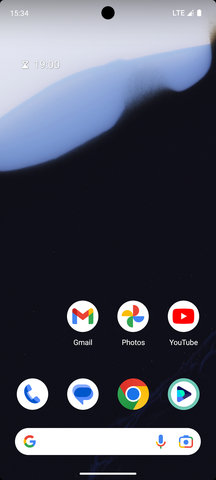

policy_source: strong
conclusion: I swiped up on the home screen to open the app drawer to find the Settings app.
thinking_refine: The user's goal is to modify notification settings for the VLC app, specifically to disable them and verify the change by filtering for turned-off apps. Currently, the device is on the home screen, displaying icons for Gmail, Photos, YouTube, and several dock apps like Phone and Chrome. The Settings app, which is required to access notification configurations, is not visible on this screen. To locate it, I need to access the full list of installed applications. The standard method to open the app drawer on this interface is to swipe upwards from the bottom area of the screen. Therefore, I will perform a swipe-up gesture to reveal the app drawer and find the Settings icon.
<thinking>
The user wants to modify notification settings for the VLC app. I am currently on the home screen. I need to access the Settings app. Since the Settings app icon is not visible 

### Step 1

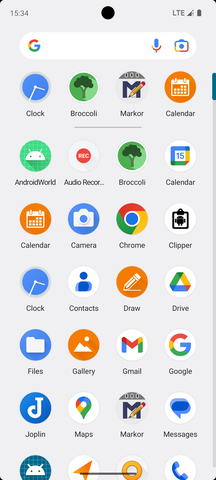

policy_source: strong
conclusion: I swiped up on the screen to scroll down the app drawer and locate the Settings app.
thinking_refine: The user's goal is to access the Settings app to modify notification preferences for VLC. Following the previous action of opening the app drawer, the current screen displays a grid of installed applications such as Clock, Calendar, Camera, and Chrome. A quick scan of the visible icons reveals that the "Settings" app is not currently present on this page. Since the app drawer typically arranges apps alphabetically or in a grid that extends vertically, the Settings app is likely located further down the list. Therefore, I need to scroll down the app drawer to bring the Settings icon into view. I will perform a swipe up action to scroll the content downwards.
<thinking>
I need to find the Settings app to proceed with the user's request. The current screen shows the app drawer, but the Settings app is not visible. I will swipe up to scroll down and look f

### Step 2

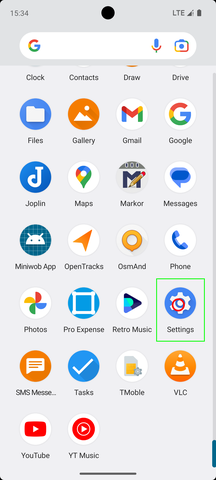

policy_source: strong
conclusion: I tapped the Settings app icon to open the Settings application.
thinking_refine: The user's goal is to modify notification settings for the VLC app, which requires accessing the system settings first. Following the previous steps where I opened the app drawer and scrolled down, I have now successfully located the "Settings" app icon on the current screen, visible in the lower right section among other applications. To proceed with the task, I need to launch the Settings app. Therefore, I will tap on the "Settings" icon to open the main configuration menu, from where I can navigate to the notification preferences.
<thinking>
I have located the Settings app in the app drawer. I will now tap on the Settings icon to open the application settings menu.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [825, 635]}}
</tool_call>
<conclusion>
I tapped the Settings app icon to open the settings.
</conclusion>
-------

### Step 3

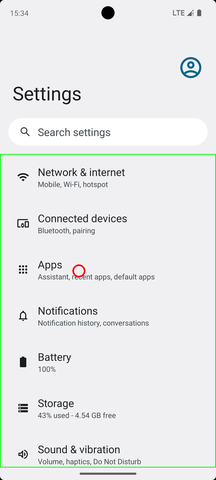

policy_source: weak
weak policy: <thinking>
The user wants to manage specific notification settings for the VLC app within the Android system. Having successfully navigated from the home screen through the app drawer and opened the Settings application in the previous steps, I am now presented with the main Settings menu. To fulfill the request, I need to locate the section where individual application behaviors are managed. Looking at the available options, "Apps" is the most direct path to access the application list and their respective notification toggles. While there is a "Notifications" entry, that typically handles system-wide notification categories. By selecting "Apps," I will be able to view all installed applications, find VLC, and subsequently disable its notifications as requested. Therefore, my next logical action is to tap on the "Apps" menu item to proceed toward the application-specific settings.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "

### Step 4

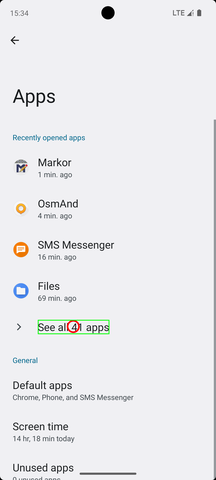

policy_source: strong
conclusion: I clicked on "See all 41 apps" to view the full list of installed applications in order to locate the VLC app.
thinking_refine: I have successfully navigated to the 'Apps' section within the Settings menu. My current objective is to locate the VLC application to modify its notification settings. Upon reviewing the current screen, I see a section for 'Recently opened apps', but VLC is not listed among them. To find the VLC app, I need to access the complete list of installed applications on the device. The option 'See all 41 apps' is clearly visible below the recent apps list, which will expand the view to show every installed app. Therefore, I will tap on this option to proceed with locating VLC.
<thinking>
I am currently in the 'Apps' section of the Settings. To find the VLC app and modify its notification settings, I need to view the full list of installed applications. Therefore, I will tap on 'See all 41 apps'.
</thinking>
<tool_call>
{"name": "mob

### Step 5

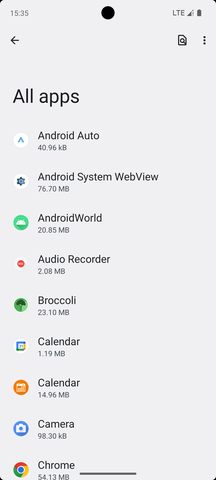

policy_source: strong
conclusion: I swiped up to scroll down the list of applications to locate the VLC app.
thinking_refine: I have successfully navigated to the "All apps" screen to locate the VLC application as part of the instruction to disable its notifications. The current view displays applications sorted alphabetically, showing apps from "Android Auto" to "Chrome". Since the target application is "VLC", which starts with the letter 'V', it will be located near the bottom of this alphabetical list. Therefore, I need to scroll down significantly to find it. I will perform a swipe up gesture to scroll down the list and search for the VLC app.
<thinking>
I am currently viewing the list of all applications, which is sorted alphabetically. The visible apps range from "Android Auto" to "Chrome". Since I need to find the "VLC" app, which starts with 'V', I need to scroll down the list. I will perform a swipe up action to scroll down.
</thinking>
<tool_call>
{"name": "mobile_use", "argu

### Step 6

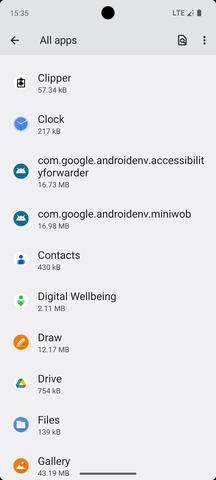

policy_source: strong
conclusion: I swiped up to scroll further down the list of applications to locate the VLC app.
thinking_refine: I am currently navigating the 'All apps' list within Settings to locate the VLC application for the purpose of disabling its notifications. The list is organized alphabetically, and the current view displays applications ranging from 'Clipper' to 'Gallery'. Since 'VLC' begins with the letter 'V', it will be located much further down the list than the currently visible apps starting with 'C' through 'G'. Consequently, I need to continue scrolling down the page to advance through the alphabet and bring the VLC app into view.
<thinking>
The current screen shows apps from 'C' to 'G'. I need to find the VLC app, which starts with 'V'. Therefore, I need to scroll down further to locate it.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "swipe", "coordinate": [500, 800], "coordinate2": [500, 200]}}
</tool_call>
<conclusion>
I swiped up t

### Step 7

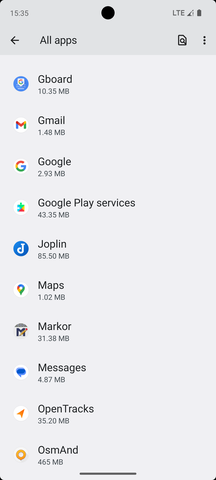

policy_source: strong
conclusion: I swiped up to scroll down the list of applications to continue searching for the VLC app.
thinking_refine: The goal is to disable notifications for the VLC app and verify the change. I am currently navigating through the "All apps" list in the Settings menu to locate the VLC application. The previous steps involved opening the full app list and scrolling down. The current screen displays applications alphabetically ranging from "Gboard" to "OsmAnd". Since the list is sorted alphabetically and "VLC" starts with "V", it will appear further down the list after "OsmAnd". Therefore, I need to perform another swipe action to scroll down and reveal the remaining applications.
<thinking>
I am currently viewing the list of apps, but I only see apps up to 'OsmAnd'. Since I need to find the VLC app, which starts with 'V', I need to scroll down further.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "swipe", "coordinate": [500, 800], "coor

### Step 8

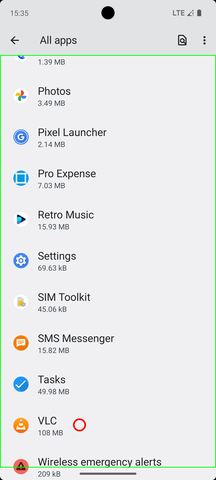

policy_source: strong
conclusion: I tapped on the VLC app to open its App Info page and access its notification settings.
thinking_refine: The user's objective is to disable notifications for the VLC app, which requires accessing its specific App Info page. Following the previous steps where I navigated to the "See all apps" list and scrolled down repeatedly, I have now successfully located the VLC app near the bottom of the current view. Since the target app is visible, no further scrolling is necessary. I will now tap on the VLC entry to open its settings menu, which is the prerequisite for finding and disabling the notification toggle as requested.
<thinking>
I have located the VLC app in the list of applications. I will now tap on it to open its App Info page so I can access its notification settings.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [368, 885]}}
</tool_call>
<conclusion>
I tapped on the VLC app to open its settings.
</co

### Step 9

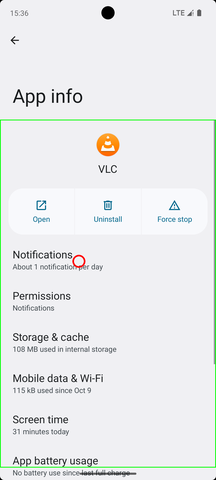

policy_source: strong
conclusion: I tapped on "Notifications" to access the notification settings for the VLC app.
thinking_refine: The user's goal is to disable notifications for the VLC app and then verify the change. Following the previous steps, I have successfully navigated to the "App info" page for VLC. The current screen displays various settings for the app, including options for "Notifications," "Permissions," and "Storage & cache." To proceed with the instruction, I need to access the specific notification controls for this application. The "Notifications" menu item is clearly visible near the top of the list. Tapping this option will allow me to toggle the notification settings off, which is the immediate next requirement.
<thinking>
I am currently on the App info page for VLC. To disable notifications as requested, I need to access the notification settings. I will tap on the "Notifications" option.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "cl

### Step 10

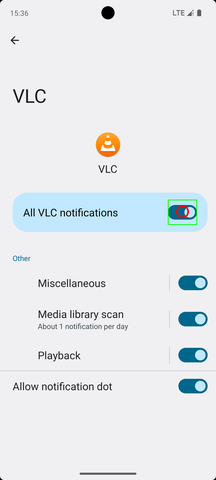

policy_source: strong
conclusion: I tapped the "All VLC notifications" toggle to disable notifications for the VLC app.
thinking_refine: I have successfully navigated to the notification settings page for the VLC app. Observing the current screen state, the master toggle labeled "All VLC notifications" is currently enabled. In accordance with the user's instruction to disable notifications for VLC, I must interact with this specific toggle to turn it off. This action will effectively block all notifications from the application. Once this step is complete, I will be ready to return to the previous menu to adjust the list filter and verify that VLC appears under the "Turned off" category.
<thinking>
I am currently in the notification settings for the VLC app. The "All VLC notifications" toggle is currently enabled. I need to tap this toggle to disable notifications for the VLC app as requested.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate":

### Step 11

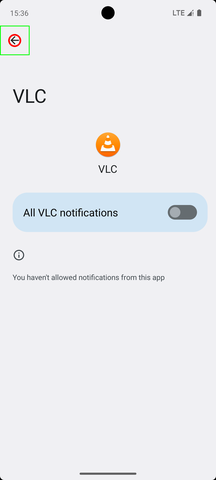

policy_source: strong
conclusion: I tapped the back arrow to return to the VLC App Info screen.
thinking_refine: I have successfully disabled notifications for the VLC app, as indicated by the toggle being switched off. The next part of the instruction requires me to change the list filter to display only apps that are 'Turned off' to verify this change. This filtering option is typically located in the general 'Notifications' section of the Settings app, specifically under 'App settings', rather than within the individual app's details. Therefore, I need to navigate back from the current VLC-specific screen to the main settings or apps list to locate the correct menu. I will start by tapping the back arrow in the top-left corner to return to the previous screen.
<thinking>
I have successfully disabled the notifications for VLC. Now I need to navigate to a screen where I can filter the app list by "Turned off" status to verify the change. This feature is typically located in the "Notif

### Step 12

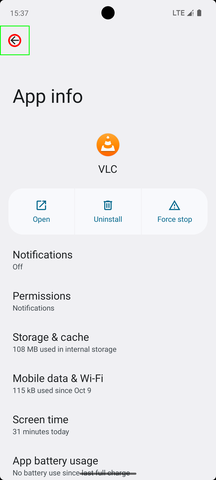

policy_source: strong
conclusion: I tapped the back arrow to return to the main list of applications.
thinking_refine: I have successfully disabled notifications for the VLC app, as indicated by the "Notifications" status showing "Off" on the current App Info screen. The next part of the instruction requires me to change the list filter to display only apps that are 'Turned off' to verify the change. To access the filter options, I need to return to the main "All apps" list view, as the current screen is specific to VLC settings. Therefore, I will tap the back arrow in the top-left corner to navigate back to the previous list of applications.
<thinking>
I am currently on the App Info page for VLC. To proceed with the user's request of changing the list filter to display only apps that are 'Turned off', I need to return to the main list of applications. Therefore, I will tap the back arrow in the top-left corner.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "cl

### Step 13

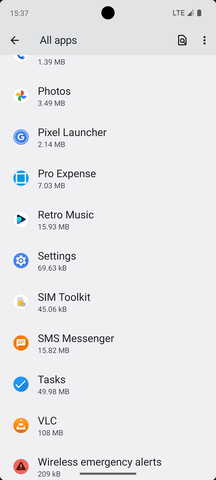

policy_source: strong
conclusion: I tapped the Back button to return to the previous menu, aiming to navigate to the correct notification settings area to filter the app list by status.
thinking_refine: Having successfully disabled notifications for the VLC app, the remaining task is to verify this action by filtering the application list to show only those with notifications 'Turned off'. I am currently on the "All apps" screen, which lists installed applications alphabetically. However, this specific screen does not provide the dropdown filter for notification status (such as "Most recent" or "Turned off"). That filtering functionality is typically located within the "Notifications" section of the main Settings menu, often under "App settings." Since I am currently inside the "Apps" submenu, I need to navigate upwards to reach the main Settings list again. Therefore, I will press the system Back button to exit the current list and proceed toward the Notifications menu.
<thinking>
I h

### Step 14

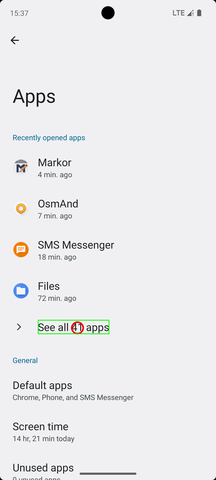

policy_source: weak
weak policy: <thinking>
The user's objective is to verify that VLC's notifications have been successfully disabled by filtering the application list to show only apps with "Turned off" notification statuses. Having just returned from the specific notification settings page for VLC, I am now back on the main "Apps" settings screen. To proceed with the verification step, I need to access the comprehensive list of all installed applications. The current screen displays a "Recently opened apps" section, but to find VLC and apply the required filter, I must view the complete directory of apps. Therefore, I will tap on the "See all 41 apps" option. This will allow me to locate VLC again and access its notification toggle, ensuring the state is correctly updated to "Turned off" before I finally apply the list filter to confirm the change across the system.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [391, 1644]}}
</tool_cal

### Step 15

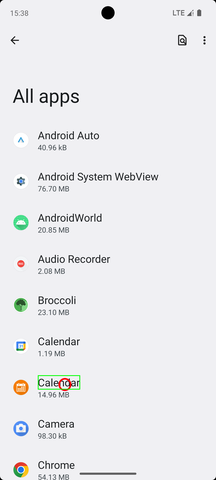

policy_source: weak
weak policy: <thinking>
I have successfully disabled the notifications for the VLC app and returned to the "All apps" list to fulfill the final part of the instruction: changing the list filter to display only apps that are 'Turned off'. Currently, I am looking at the top of the application list, which includes system apps like Android Auto and Chrome. Since the list is sorted alphabetically, I need to navigate much further down to reach the 'V' section where VLC is located. My previous attempts to scroll this long list resulted in only minor progress, indicating that a more efficient method is needed to reach the target entry. To jump directly to the VLC row without scrolling through the entire list, I will perform a long-press on the "VLC" label. This action should trigger the context menu, providing a shortcut to the app's specific settings page. From there, I can access the notification settings again to apply the requested filter and verify the state of VLC and

### Step 16

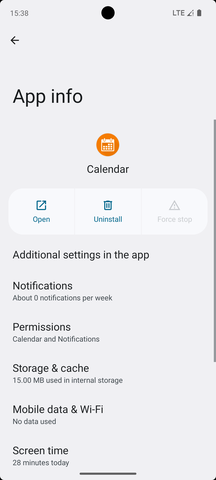

policy_source: strong
conclusion: I pressed the Back button to exit the incorrect Calendar App info screen and return to the previous menu.
thinking_refine: The current screen displays the App Info page for "Calendar," which indicates a deviation from the intended task of verifying VLC notifications. It appears that a previous interaction, possibly an accidental tap while navigating the app list, opened the wrong application's settings instead of the intended target. Since the Calendar settings are irrelevant to the goal of filtering the notification list to show apps with notifications turned off, I need to exit this screen immediately. Pressing the system Back button will return me to the previous menu, likely the full application list or the main Apps settings, allowing me to resume the correct navigation path to locate the filter options.
<thinking>
I am currently on the App info screen for Calendar, which is not the correct location. I need to navigate to the notification settings

### Step 17

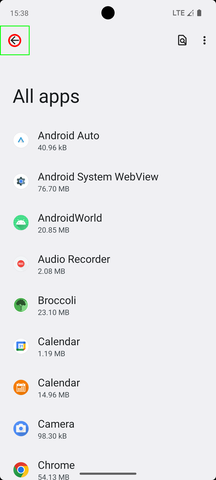

policy_source: strong
conclusion: I tapped the back arrow to return to the previous settings screen, aiming to locate the "Notifications" menu to filter apps by their notification status.
thinking_refine: The primary goal is to verify that notifications for the VLC app are disabled by filtering the app list to show only those with notifications 'Turned off'. Currently, I am on the 'All apps' screen, which lists every installed application alphabetically but does not provide the specific dropdown filter for notification status (such as 'Most recent' or 'Turned off'). This screen is intended for general app management rather than notification filtering. To access the correct view, I need to return to the main 'Apps' or 'Notifications' settings menu, where the option to filter applications by their notification state is typically located. Therefore, navigating back is the necessary step to exit the current list and locate the appropriate settings interface.
<thinking>
I am currently in th

### Step 18

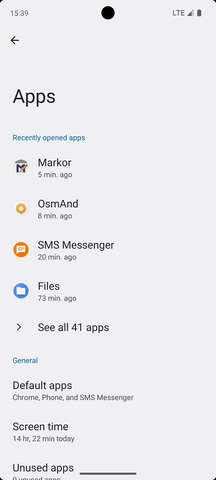

policy_source: strong
conclusion: I pressed the Back button to return to the main Settings menu, intending to locate the "Notifications" section to filter apps by their notification status.
thinking_refine: I have successfully disabled notifications for the VLC app and am currently positioned on the "Apps" screen. The next objective is to verify this change by filtering the application list to show only those with notifications turned off. Examining the current screen, I see options for "Recently opened apps," "Default apps," and "Screen time," but there is no feature here to view or filter global app notification settings. This specific filter is typically located within the main "Notifications" menu of the system settings, rather than the general "Apps" menu. To access that section, I need to exit the current screen and return to the main Settings list. Therefore, I will press the Back button to navigate back to the top-level Settings menu.
<thinking>
I am currently in the "Apps" men

### Step 19

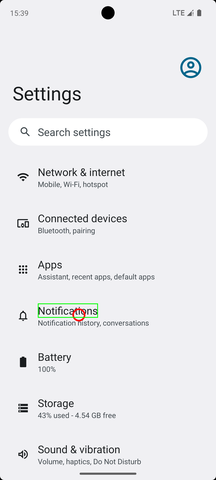

policy_source: strong
conclusion: I tapped on "Notifications" to access the notification settings menu, intending to filter the app list to verify the changes.
thinking_refine: I have successfully disabled notifications for the VLC app in previous steps and have now returned to the main Settings menu to locate the appropriate view for verification. The next part of the instruction requires changing a list filter to display only apps that are 'Turned off'. This specific filtering functionality for app notifications is typically found within the general "Notifications" settings category, which aggregates notification preferences and lists. Although I previously navigated through the "Apps" menu to find the specific application, the global list with filter options is best accessed through the "Notifications" menu visible on the current screen. Therefore, I will tap on "Notifications" to access the app notification settings and locate the filter options.
<thinking>
I am currently on the ma

### Step 20

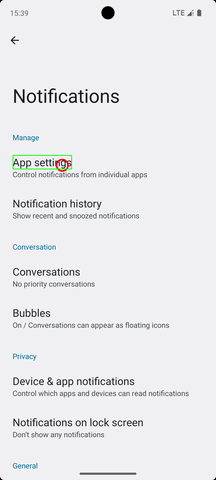

policy_source: strong
conclusion: I tapped on "App settings" to access the list of applications and their notification statuses.
thinking_refine: The notification settings for the VLC app have already been disabled in previous steps. The current goal is to verify this change by filtering the application list to show only those with notifications turned off. I am currently in the main "Notifications" menu of the Settings app. Looking at the available options, "App settings" is described as allowing me to "Control notifications from individual apps," which implies it leads to a list where I can manage and view notification statuses for all applications. This is the correct path to access the list filter functionality required by the instruction. Therefore, I will tap on "App settings" to proceed to the app list.
<thinking>
I am currently in the "Notifications" menu. To verify that notifications for VLC are disabled, I need to access the list of apps and their notification statuses. The "

### Step 21

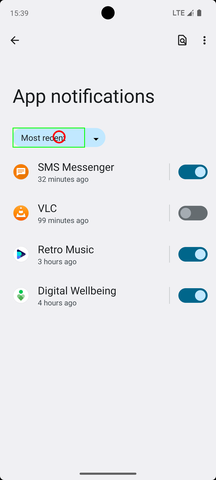

policy_source: strong
conclusion: I tapped on the "Most recent" dropdown menu to open the filter options.
thinking_refine: The current screen displays the "App notifications" menu, showing a list of applications with their notification toggles. I can see VLC in the list with its toggle already disabled, confirming the previous action was successful. However, the user instruction explicitly requires changing the list filter to display only apps that are 'Turned off' as a verification step. The current filter is set to "Most recent," indicated by a dropdown menu at the top of the list. To proceed with the verification, I need to access the filter options. Therefore, I will tap on the "Most recent" dropdown menu to reveal the available filter categories, which should include the "Turned off" option.
<thinking>
I am currently on the "App notifications" screen. The user's goal is to change the list filter to display only apps that are 'Turned off' to verify that VLC notifications are disabl

### Step 22

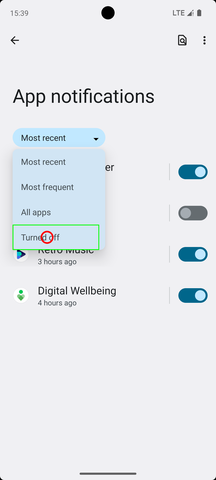

policy_source: strong
conclusion: I tapped on the "Turned off" option in the dropdown menu to filter the list of applications to show only those with notifications disabled.
thinking_refine: I have successfully navigated to the "App notifications" screen and opened the filter dropdown menu, which currently defaults to "Most recent." The goal is to verify that notifications for the VLC app have been disabled by viewing only the apps with notifications turned off. The dropdown menu displays several options, including "Most recent," "Most frequent," "All apps," and "Turned off." To fulfill the specific instruction of changing the list filter to display only apps that are 'Turned off,' I will now select the "Turned off" option from the list.
<thinking>
I have opened the dropdown menu for filtering app notifications. The user wants to filter by apps that are 'Turned off'. I can see the 'Turned off' option in the dropdown menu. I will tap on it to select this filter.
</thinking>
<tool_call>


### Step 23

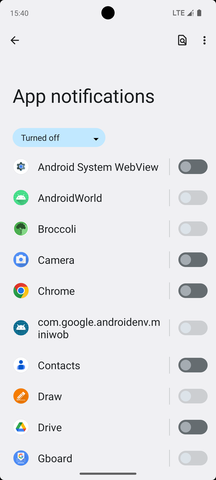

policy_source: strong
conclusion: I swiped up to scroll down the list of applications with notifications turned off to locate the VLC app.
thinking_refine: I have successfully navigated to the "App notifications" screen and applied the "Turned off" filter, as indicated by the dropdown menu at the top. The current view displays a list of applications sorted alphabetically, starting from 'A' (Android System WebView) down to 'G' (Gboard). My objective is to verify that the VLC app appears in this list, confirming that its notifications have been disabled. Since VLC starts with 'V', it will be located much further down the list. Therefore, I need to scroll down through the list of applications to locate VLC.
<thinking>
I have successfully filtered the app notifications list to show only apps with notifications "Turned off". Now I need to scroll down the list to verify that the VLC app is present, confirming that its notifications have been disabled.
</thinking>
<tool_call>
{"name": "mobile

### Step 24

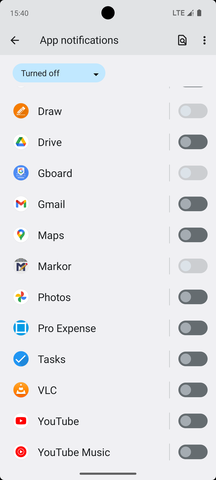

policy_source: strong
conclusion: I verified that the VLC app appeared in the "Turned off" notification list, confirming the changes, and completed the task.
thinking_refine: The current screen displays the "App notifications" menu with the filter set to "Turned off," as requested in the final part of the instructions. I can clearly see the VLC app listed near the bottom of the screen, confirming that its notifications have been successfully disabled. This step validates the earlier action of turning off the notifications and completes the requirement to verify the change using the specific list filter. Since all objectives—navigating to settings, disabling notifications for VLC, and verifying the status by filtering the list—have been achieved, the task is now complete.
<thinking>
I have successfully navigated to the notification settings, disabled notifications for the VLC app, and changed the filter to "Turned off". The current screenshot shows the "App notifications" screen with th

In [ ]:
# 从 data_merge.json 随机抽 1 条轨迹可视化
# good: 1045_SystemWifiTurnOnVerify
import random


def _annotate_bbox(img: Image.Image, bbox: dict | None):
    """如果 bbox 存在，则用绿色框标注出来（bbox 坐标为原始像素坐标）。"""
    if not bbox:
        return img

    try:
        x_min = int(bbox.get("x_min"))
        x_max = int(bbox.get("x_max"))
        y_min = int(bbox.get("y_min"))
        y_max = int(bbox.get("y_max"))
    except Exception:
        return img

    img = img.convert("RGBA")
    draw = ImageDraw.Draw(img)
    w, h = img.size

    # clamp（避免越界导致看不到框）
    x_min = max(0, min(w - 1, x_min))
    x_max = max(0, min(w - 1, x_max))
    y_min = max(0, min(h - 1, y_min))
    y_max = max(0, min(h - 1, y_max))

    stroke = max(3, int(min(w, h) * 0.004))
    draw.rectangle((x_min, y_min, x_max, y_max), outline=(0, 255, 0, 255), width=stroke)
    return img


def show_random_from_merged(
    runs_dir: Path = RUNS_DIR,
    seed: int | None = None,
    max_steps: int | None = None,
    display_scale: float = 0.2,
    only_has_unreasonable: bool = False,
):
    if seed is not None:
        random.seed(seed)

    merge_path = runs_dir / "data_merge_0224_refine_conclusion_thinking.json"
    merged = json.loads(merge_path.read_text(encoding="utf-8"))
    if not merged:
        raise ValueError(f"data_merge.json 为空：{merge_path}")

    # # filter specific app/task
    # print(f"Num of total tasks: {len(merged)}")
    # merged = [item for item in merged if item["goal"] == "In the VLC app, navigate to the settings to change the interface theme to 'Dark' and set the 'Video hardware acceleration' to 'Full acceleration'."]
    # print(f"Num of filtered tasks: {len(merged)}")

    item = random.choice(merged)
    goal = item.get("goal", "")
    traj = item.get("trajectory") or []
    if max_steps is not None:
        traj = traj[:max_steps]

    display(Markdown(f"## {item.get('save_dir','')}\n\n**Goal**: {goal}"))

    for step_obj in traj:
        step = step_obj.get("step")
        response = step_obj.get("response", "")
        actions = _extract_click_actions(response)
        bbox = step_obj.get("bbox")

        display(Markdown(f"### Step {step}"))

        img_rel = step_obj.get("image")
        img_path = (runs_dir / img_rel) if img_rel else None
        if img_path and img_path.exists():
            img = Image.open(img_path)
            img = _annotate_clicks(img, actions)
            img = _annotate_bbox(img, bbox)
            display(_resize_for_display(img, display_scale))
        else:
            print(f"[缺少截图] {img_rel}")

        # 新增字段打印
        if "policy_source" in step_obj:
            print(f"policy_source: {step_obj.get('policy_source')}")
        if step_obj.get("policy_source") == "weak":
            response_weak = step_obj.get("response_weak")
            print(f"weak policy: {response_weak}")
            response_strong = step_obj.get("response_strong")
            print(f"strong policy: {response_strong}")
        if "is_reasonable" in step_obj:
            print(f"is_reasonable: {step_obj.get('is_reasonable')}")
        if step_obj.get("conclusion"):
            print(f"conclusion: {step_obj.get('conclusion')}")
        if step_obj.get("thinking_refine"):
            print(f"thinking_refine: {step_obj.get('thinking_refine')}")
        if step_obj.get("thinking_pattern"):
            print(f"thinking_pattern: {step_obj.get('thinking_pattern')}")

        print(response)
        print("-" * 80)

    return item


# 运行这个：从 data_merge.json 随机抽 1 条可视化
_ = show_random_from_merged(only_has_unreasonable=True)
# _ = show_random_from_merged()

In [ ]:
# 发现“前后截图完全无变化”的 step，并随机可视化 1 个（不改数据，仅展示）
import random
from PIL import ImageChops
from tqdm import tqdm


def _images_identical_pixels(p1: Path, p2: Path) -> bool:
    """严格像素级一致（RGB）。"""
    try:
        with Image.open(p1) as im1, Image.open(p2) as im2:
            im1 = im1.convert("RGB")
            im2 = im2.convert("RGB")
            if im1.size != im2.size:
                return False
            return ImageChops.difference(im1, im2).getbbox() is None
    except Exception:
        return False


def show_random_static_step(
    runs_dir: Path = RUNS_DIR,
    seed: int | None = None,
    display_scale: float = 0.2,
    max_pairs: int | None = None,
):
    if seed is not None:
        random.seed(seed)

    merge_path = runs_dir / "data_merge_0208.json"
    merged = json.loads(merge_path.read_text(encoding="utf-8"))
    if not merged:
        raise ValueError(f"merged 为空：{merge_path}")

    candidates = []
    checked = 0

    for ep_idx, ep in tqdm(enumerate(merged)):
        traj = ep.get("trajectory") or []
        for i in range(len(traj) - 1):
            if max_pairs is not None and checked >= max_pairs:
                break
            s1, s2 = traj[i], traj[i + 1]
            img1_rel = s1.get("image")
            img2_rel = s2.get("image")
            if not img1_rel or not img2_rel:
                continue
            p1 = runs_dir / img1_rel
            p2 = runs_dir / img2_rel
            if not (p1.exists() and p2.exists()):
                continue

            checked += 1
            if _images_identical_pixels(p1, p2):
                candidates.append((ep_idx, i))

        if max_pairs is not None and checked >= max_pairs:
            break

    print(f"Checked pairs: {checked}")
    print(f"Static-step candidates: {len(candidates)}")
    if not candidates:
        raise ValueError("未找到任何前后截图完全一致的 step")

    ep_idx, i = random.choice(candidates)
    ep = merged[ep_idx]
    traj = ep.get("trajectory") or []
    s1, s2 = traj[i], traj[i + 1]

    goal = ep.get("goal", "")
    save_dir = ep.get("save_dir", "")

    display(Markdown(f"## Static Step Sample: {save_dir}\n\n**Goal**: {goal}\n\n- step_idx_in_traj: {i} → {i+1}\n- step_id: {s1.get('step')} → {s2.get('step')}"))

    # 当前 step
    response1 = s1.get("response", "")
    actions1 = _extract_click_actions(response1) if "_extract_click_actions" in globals() else []
    bbox1 = s1.get("bbox")

    display(Markdown(f"### Step {s1.get('step')}（当前）"))
    img1_path = runs_dir / s1.get("image")
    if img1_path.exists():
        img1 = Image.open(img1_path)
        if "_annotate_clicks" in globals():
            img1 = _annotate_clicks(img1, actions1)
        if "_annotate_bbox" in globals():
            img1 = _annotate_bbox(img1, bbox1)
        display(_resize_for_display(img1, display_scale) if "_resize_for_display" in globals() else img1)
    else:
        print(f"[缺少截图] {img1_path}")
    print(response1)

    # 下一步 step（对照图）
    response2 = s2.get("response", "")
    actions2 = _extract_click_actions(response2) if "_extract_click_actions" in globals() else []
    bbox2 = s2.get("bbox")

    display(Markdown(f"### Step {s2.get('step')}（下一步/对照）"))
    img2_path = runs_dir / s2.get("image")
    if img2_path.exists():
        img2 = Image.open(img2_path)
        if "_annotate_clicks" in globals():
            img2 = _annotate_clicks(img2, actions2)
        if "_annotate_bbox" in globals():
            img2 = _annotate_bbox(img2, bbox2)
        display(_resize_for_display(img2, display_scale) if "_resize_for_display" in globals() else img2)
    else:
        print(f"[缺少截图] {img2_path}")
    print(response2)

    return {"ep_idx": ep_idx, "step_i": i, "save_dir": save_dir}


# 运行：随机可视化 1 个“前后截图无变化”的 step
_ = show_random_static_step()